# Libreria

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
from pprint import pprint
from toolz.dicttoolz import valmap
from tensorflow import keras
import tensorflow as tf
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error,max_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, max_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM
import datetime as dt

In [ ]:
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump,load
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
SEED = 7
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# PreProcesamiento de Datos

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/NuevoTPIA.csv')
df.head(5)

,Unnamed: 0,SIN Imputed,T02M,RH2M,PRSS,TPP6,U10M,V10M
0,2008-01-01 00:00:00-03:00,877.658352,24.463579,96.798320,999.585909,0.000629,-1.613880,-1.142420
1,2008-01-01 01:00:00-03:00,855.606858,24.314531,96.065988,999.059392,0.000419,-1.624135,-1.256589
2,2008-01-01 02:00:00-03:00,803.357910,24.165483,95.333657,998.532875,0.000210,-1.634390,-1.370759
3,2008-01-01 03:00:00-03:00,750.530366,24.016435,94.601325,998.006359,0.000000,-1.644645,-1.484929
4,2008-01-01 04:00:00-03:00,729.029900,23.667572,94.257455,998.982867,0.000000,-1.273453,-1.629541


In [ ]:
nombres_nuevos = ['Fecha', 'Potencia', 'Temperatura','Humedad','Presión', 'Precipitacion', 'U','V']
# Cambiar los nombres de las columnas
df.columns = nombres_nuevos
df.head(20)

,Fecha,Potencia,Temperatura,Humedad,Presión,Precipitacion,U,V
0,2008-01-01 00:00:00-03:00,877.658352,24.463579,96.798320,999.585909,0.000629,-1.613880,-1.142420
1,2008-01-01 01:00:00-03:00,855.606858,24.314531,96.065988,999.059392,0.000419,-1.624135,-1.256589
2,2008-01-01 02:00:00-03:00,803.357910,24.165483,95.333657,998.532875,0.000210,-1.634390,-1.370759
3,2008-01-01 03:00:00-03:00,750.530366,24.016435,94.601325,998.006359,0.000000,-1.644645,-1.484929
4,2008-01-01 04:00:00-03:00,729.029900,23.667572,94.257455,998.982867,0.000000,-1.273453,-1.629541
5,2008-01-01 05:00:00-03:00,717.195424,23.318710,93.913586,999.959376,0.000000,-0.902261,-1.774154
6,2008-01-01 06:00:00-03:00,636.497140,22.969847,93.569716,1000.935885,0.000000,-0.531068,-1.918767
7,2008-01-01 07:00:00-03:00,566.063757,24.355974,88.873767,1001.222567,0.000000,-0.609305,-2.025998
8,2008-01-01 08:00:00-03:00,543.269824,25.742102,84.177818,1001.509249,0.000000,-0.687541,-2.133229
9,2008-01-01 09:00:00-03:00,564.513991,27.128229,79.481869,1001.795931,0.000000,-0.765778,-2.240461


In [ ]:
# Función para categorizar la dirección del viento en Norte o Sur
def categorizar_direccion1(direccion):
    if direccion >= 0:
        return 'U1'
    else:
        return 'U2'
def categorizar_direccion2(direccion):
    if direccion >= 0:
        return 'V1'
    else:
        return 'V2'

# Aplicamos la función de categorización a la columna de dirección del viento
df['DirecciónU'] = df['U'].apply(categorizar_direccion1)
df['DirecciónV'] = df['V'].apply(categorizar_direccion2)

# Calculamos la magnitud del viento utilizando el teorema de Pitágoras
df['Magnitud'] = np.sqrt(np.square(df['U']) + np.square(df['V']))

# Categorizamos la magnitud en tres niveles de cuartil
df['Cuartil de Magnitud'] = pd.qcut(df['Magnitud'], q=3, labels=["Bajo", "Medio", "Alto"])

# Mostramos el DataFrame resultante
df

,Fecha,Potencia,Temperatura,Humedad,Presión,Precipitacion,U,V,DirecciónU,DirecciónV,Magnitud,Cuartil de Magnitud
0,2008-01-01 00:00:00-03:00,877.658352,24.463579,96.798320,999.585909,0.000629,-1.613880,-1.142420,U2,V2,1.977304,Bajo
1,2008-01-01 01:00:00-03:00,855.606858,24.314531,96.065988,999.059392,0.000419,-1.624135,-1.256589,U2,V2,2.053493,Bajo
2,2008-01-01 02:00:00-03:00,803.357910,24.165483,95.333657,998.532875,0.000210,-1.634390,-1.370759,U2,V2,2.133122,Medio
3,2008-01-01 03:00:00-03:00,750.530366,24.016435,94.601325,998.006359,0.000000,-1.644645,-1.484929,U2,V2,2.215823,Medio
4,2008-01-01 04:00:00-03:00,729.029900,23.667572,94.257455,998.982867,0.000000,-1.273453,-1.629541,U2,V2,2.068112,Bajo
...,...,...,...,...,...,...,...,...,...,...,...,...
131457,2022-12-31 19:00:00-03:00,2917.003684,35.666498,25.449116,995.890558,0.000000,-3.664459,-0.515961,U2,V2,3.700605,Alto
131458,2022-12-31 20:00:00-03:00,3214.912340,33.147940,29.386493,996.157851,0.000000,-3.195860,-0.236700,U2,V2,3.204614,Alto
131459,2022-12-31 21:00:00-03:00,3280.046574,30.629383,33.323870,996.425145,0.000000,-2.727261,0.042562,U2,V1,2.727593,Medio
131460,2022-12-31 22:00:00-03:00,2955.971259,29.699868,35.320626,997.416281,0.000000,-2.576113,-0.518552,U2,V2,2.627785,Medio


# Interpretacion de Datos

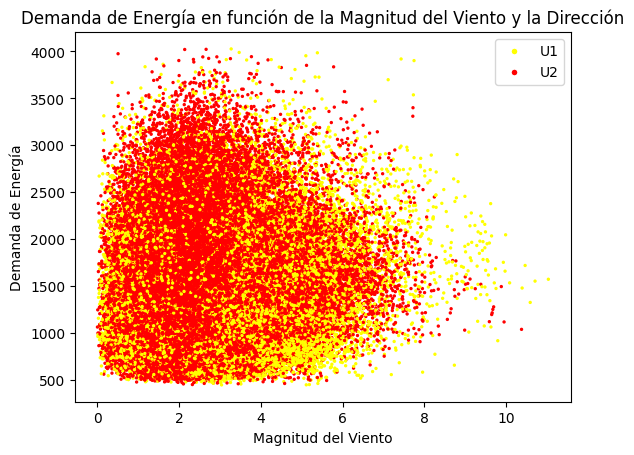

In [ ]:
plt.scatter(df['Magnitud'], df['Potencia'], c=df['DirecciónU'].map({'U1': 'yellow', 'U2': 'red'}),s=2)
plt.xlabel('Magnitud del Viento')
plt.ylabel('Demanda de Energía')
plt.title('Demanda de Energía en función de la Magnitud del Viento y la Dirección')
plt.legend(['U1','U2'])
yellow_patch = plt.Line2D([0], [0], marker='o', color='w', label='U1', markerfacecolor='yellow', markersize=5)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='U2', markerfacecolor='red', markersize=5)
plt.legend(handles=[yellow_patch, red_patch])
plt.show()

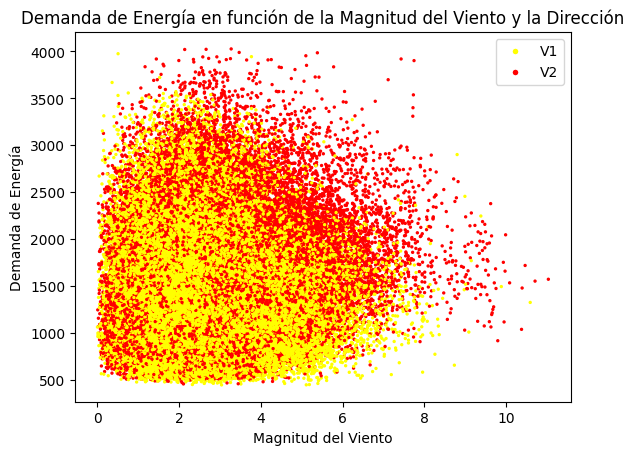

In [ ]:
# Gráfico de dispersión con colores según la dirección del viento
plt.scatter(df['Magnitud'], df['Potencia'], c=df['DirecciónV'].map({'V1': 'yellow', 'V2': 'red'}), s=2)

# Etiqueta de ejes y título del gráfico
plt.xlabel('Magnitud del Viento')
plt.ylabel('Demanda de Energía')
plt.title('Demanda de Energía en función de la Magnitud del Viento y la Dirección')

# Elementos de la leyenda manualmente
yellow_patch = plt.Line2D([0], [0], marker='o', color='w', label='V1', markerfacecolor='yellow', markersize=5)
red_patch = plt.Line2D([0], [0], marker='o', color='w', label='V2', markerfacecolor='red', markersize=5)
plt.legend(handles=[yellow_patch, red_patch])

# Mostrar el gráfico
plt.show()

In [ ]:
df['Fecha'] = df['Fecha'].astype(str)
df['Hora'] = df['Fecha'].str.split(' ').str[1]
df['Fecha']=df['Fecha'].str.split(' ').str[0]
df['Hora']=df['Hora'].str.split('-').str[0]
# Convertir la columna 'Hora' al formato correcto (solo horas como enteros)
df['Hora'] = df['Hora'].apply(lambda x: int(x.split(':')[0]))

<ipython-input-10-cb60f0013420>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))


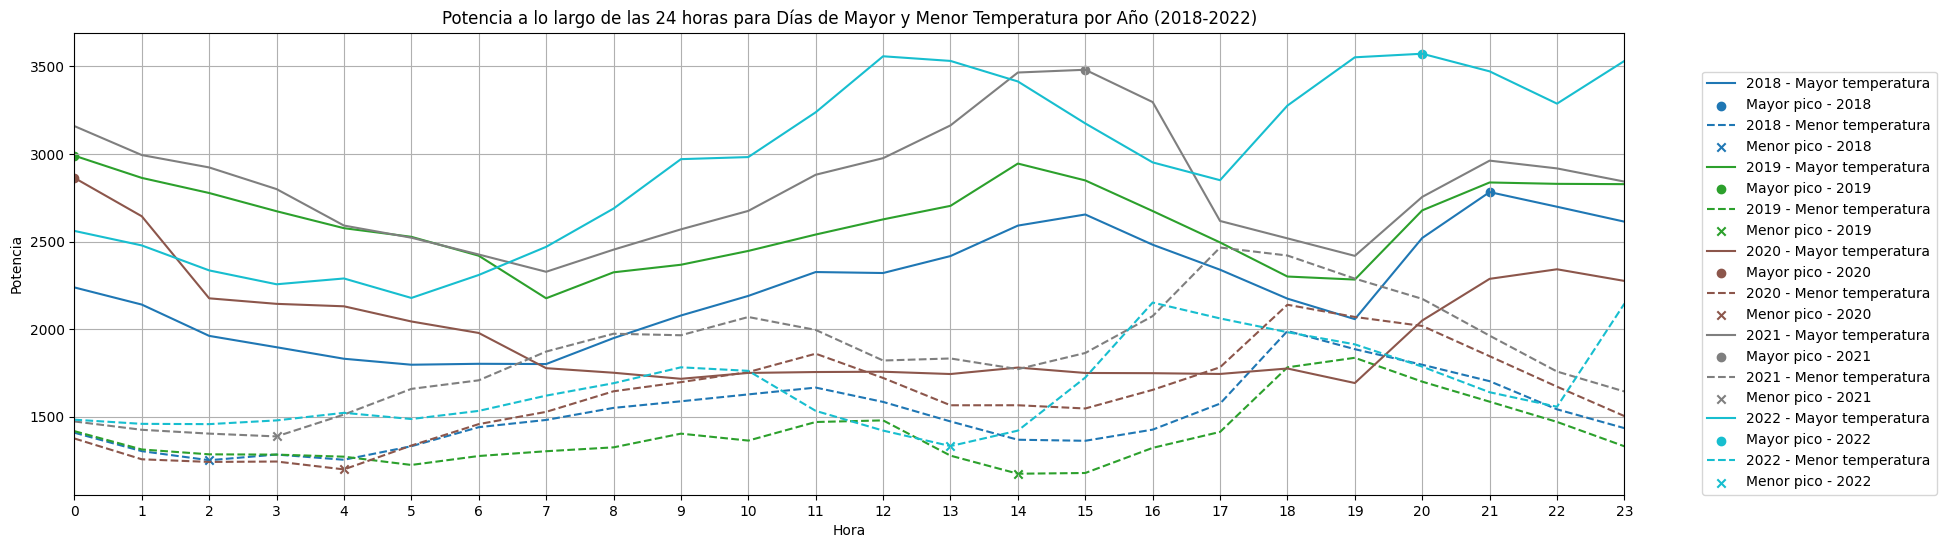

In [ ]:
# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Obtener el año de cada fecha
df['Año'] = df['Fecha'].dt.year

# Filtrar los días con la mayor temperatura de cada año
mayor_temperatura_por_año = df.loc[df.groupby('Año')['Temperatura'].idxmax()]

# Filtrar los días con la menor temperatura de cada año
menor_temperatura_por_año = df.loc[df.groupby('Año')['Temperatura'].idxmin()]

# Crear un gráfico para visualizar la potencia a lo largo de las 24 horas del día
plt.figure(figsize=(20, 6))

# Colormap para asignar un color único a cada año
colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))

# Iterar sobre cada año de 2018 a 2022
for i, year in enumerate(range(2018, 2023)):
    # Filtrar el día de mayor temperatura para el año actual
    mayor_temperatura_actual = mayor_temperatura_por_año[mayor_temperatura_por_año['Año'] == year]
    mayor_temperatura_fecha = mayor_temperatura_actual['Fecha'].iloc[0]
    mayor_temperatura_dia = df[(df['Fecha'] == mayor_temperatura_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    mayor_temperatura_dia = mayor_temperatura_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de mayor temperatura del año actual
    plt.plot(mayor_temperatura_dia['Hora'], mayor_temperatura_dia['Potencia'],
             label=f'{year} - Mayor temperatura', color=colormap(i))

    # Señalar el mayor pico de potencia en el día de mayor temperatura
    mayor_pico_potencia = mayor_temperatura_dia.loc[mayor_temperatura_dia['Potencia'].idxmax()]
    plt.scatter(mayor_pico_potencia['Hora'], mayor_pico_potencia['Potencia'], color=colormap(i), marker='o', label=f'Mayor pico - {year}')

    # Filtrar el día de menor temperatura para el año actual
    menor_temperatura_actual = menor_temperatura_por_año[menor_temperatura_por_año['Año'] == year]
    menor_temperatura_fecha = menor_temperatura_actual['Fecha'].iloc[0]
    menor_temperatura_dia = df[(df['Fecha'] == menor_temperatura_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    menor_temperatura_dia = menor_temperatura_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de menor temperatura del año actual
    plt.plot(menor_temperatura_dia['Hora'], menor_temperatura_dia['Potencia'],
             label=f'{year} - Menor temperatura', color=colormap(i), linestyle='--')

    # Señalar el menor pico de potencia en el día de menor temperatura
    menor_pico_potencia = menor_temperatura_dia.loc[menor_temperatura_dia['Potencia'].idxmin()]
    plt.scatter(menor_pico_potencia['Hora'], menor_pico_potencia['Potencia'], color=colormap(i), marker='x', label=f'Menor pico - {year}')

# Establecer etiquetas de ejes y título
plt.xlabel('Hora')
plt.ylabel('Potencia')
plt.title('Potencia a lo largo de las 24 horas para Días de Mayor y Menor Temperatura por Año (2018-2022)')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0, 23)

# Colocar la leyenda en la parte inferior derecha
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()

<ipython-input-11-54e880c8d2d8>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))


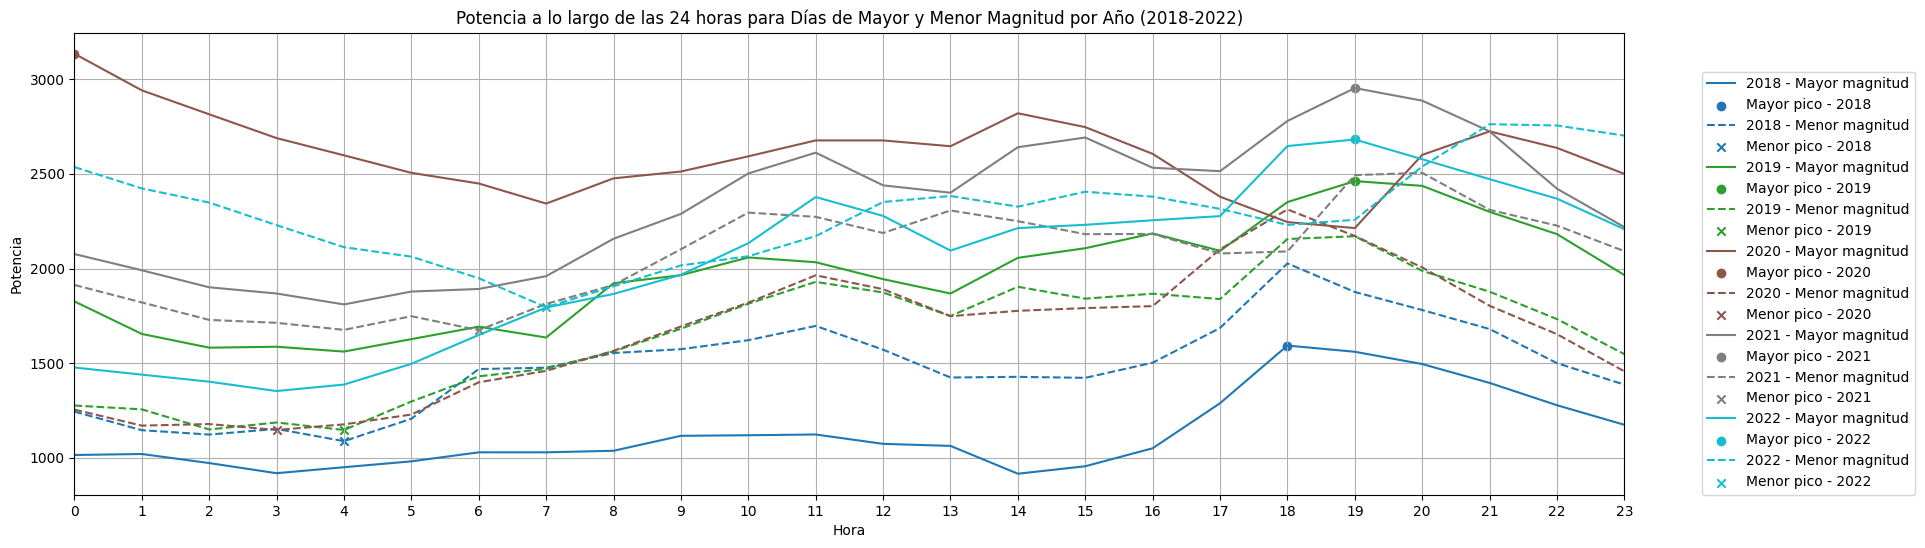

In [ ]:
# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Obtener el año de cada fecha
df['Año'] = df['Fecha'].dt.year

# Filtrar los días con la mayor magnitud de cada año
mayor_magnitud_por_año = df.loc[df.groupby('Año')['Magnitud'].idxmax()]

# Filtrar los días con la menor magnitud de cada año
menor_magnitud_por_año = df.loc[df.groupby('Año')['Magnitud'].idxmin()]

# Crear un gráfico para visualizar la potencia a lo largo de las 24 horas del día
plt.figure(figsize=(20, 6))

# Colormap para asignar un color único a cada año
colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))

# Iterar sobre cada año de 2018 a 2022
for i, year in enumerate(range(2018, 2023)):
    # Filtrar el día de mayor magnitud para el año actual
    mayor_magnitud_actual = mayor_magnitud_por_año[mayor_magnitud_por_año['Año'] == year]
    mayor_magnitud_fecha = mayor_magnitud_actual['Fecha'].iloc[0]
    mayor_magnitud_dia = df[(df['Fecha'] == mayor_magnitud_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    mayor_magnitud_dia = mayor_magnitud_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de mayor magnitud del año actual
    plt.plot(mayor_magnitud_dia['Hora'], mayor_magnitud_dia['Potencia'],
             label=f'{year} - Mayor magnitud', color=colormap(i))

    # Señalar el mayor pico de potencia en el día de mayor magnitud
    mayor_pico_potencia = mayor_magnitud_dia.loc[mayor_magnitud_dia['Potencia'].idxmax()]
    plt.scatter(mayor_pico_potencia['Hora'], mayor_pico_potencia['Potencia'], color=colormap(i), marker='o', label=f'Mayor pico - {year}')

    # Filtrar el día de menor magnitud para el año actual
    menor_magnitud_actual = menor_magnitud_por_año[menor_magnitud_por_año['Año'] == year]
    menor_magnitud_fecha = menor_magnitud_actual['Fecha'].iloc[0]
    menor_magnitud_dia = df[(df['Fecha'] == menor_magnitud_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    menor_magnitud_dia = menor_magnitud_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de menor magnitud del año actual
    plt.plot(menor_magnitud_dia['Hora'], menor_magnitud_dia['Potencia'],
             label=f'{year} - Menor magnitud', color=colormap(i), linestyle='--')

    # Señalar el menor pico de potencia en el día de menor magnitud
    menor_pico_potencia = menor_magnitud_dia.loc[menor_magnitud_dia['Potencia'].idxmin()]
    plt.scatter(menor_pico_potencia['Hora'], menor_pico_potencia['Potencia'], color=colormap(i), marker='x', label=f'Menor pico - {year}')

# Establecer etiquetas de ejes y título
plt.xlabel('Hora')
plt.ylabel('Potencia')
plt.title('Potencia a lo largo de las 24 horas para Días de Mayor y Menor Magnitud por Año (2018-2022)')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0, 23)

# Colocar la leyenda en la parte inferior derecha
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()

<ipython-input-12-f3c6efb92d05>:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))


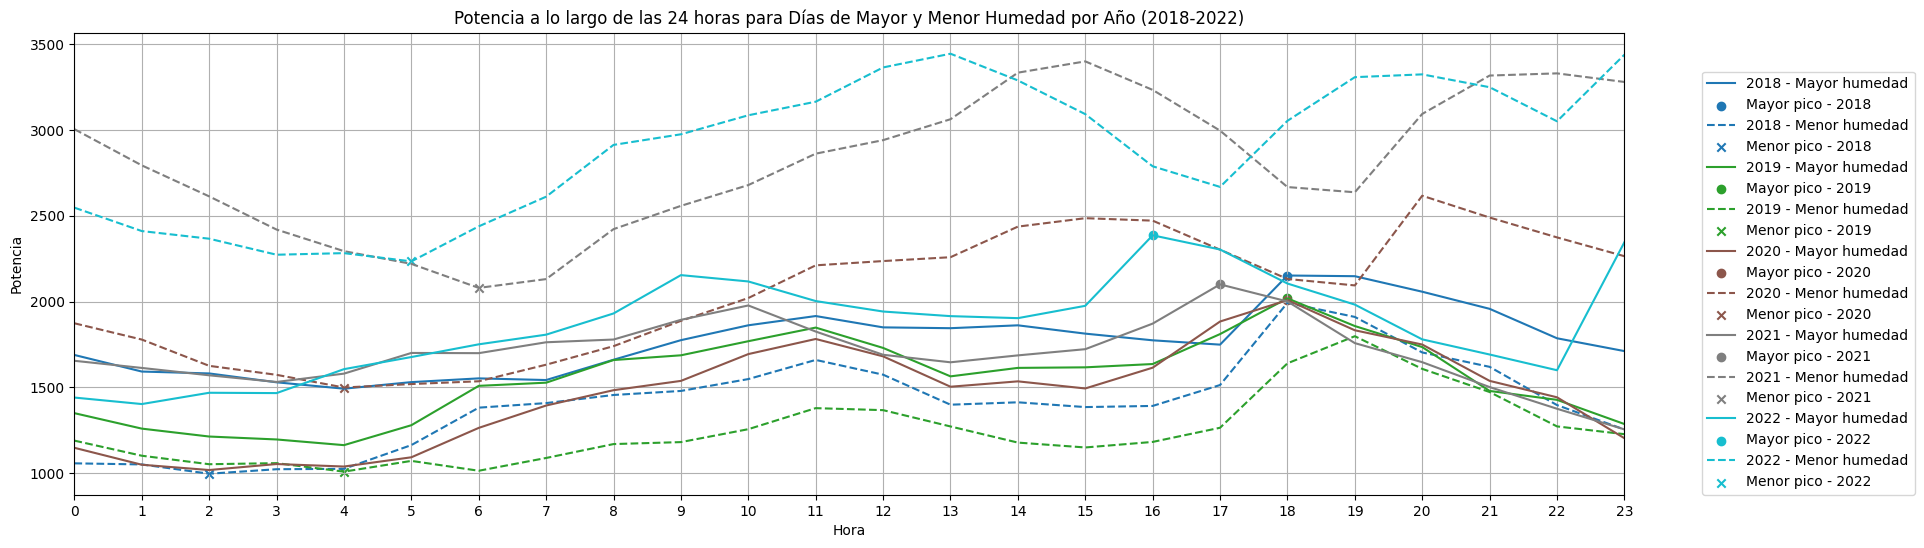

In [ ]:
# Convertir la columna 'Fecha' a tipo datetime
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Obtener el año de cada fecha
df['Año'] = df['Fecha'].dt.year

# Filtrar los días con la mayor humedad de cada año
mayor_humedad_por_año = df.loc[df.groupby('Año')['Humedad'].idxmax()]

# Filtrar los días con la menor humedad de cada año
menor_humedad_por_año = df.loc[df.groupby('Año')['Humedad'].idxmin()]

# Crear un gráfico para visualizar la potencia a lo largo de las 24 horas del día
plt.figure(figsize=(20, 6))

# Colormap para asignar un color único a cada año
colormap = plt.cm.get_cmap('tab10', len(range(2018, 2023)))

# Iterar sobre cada año de 2018 a 2022
for i, year in enumerate(range(2018, 2023)):
    # Filtrar el día de mayor humedad para el año actual
    mayor_humedad_actual = mayor_humedad_por_año[mayor_humedad_por_año['Año'] == year]
    mayor_humedad_fecha = mayor_humedad_actual['Fecha'].iloc[0]
    mayor_humedad_dia = df[(df['Fecha'] == mayor_humedad_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    mayor_humedad_dia = mayor_humedad_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de mayor humedad del año actual
    plt.plot(mayor_humedad_dia['Hora'], mayor_humedad_dia['Potencia'],
             label=f'{year} - Mayor humedad', color=colormap(i))

    # Señalar el mayor pico de potencia en el día de mayor humedad
    mayor_pico_potencia = mayor_humedad_dia.loc[mayor_humedad_dia['Potencia'].idxmax()]
    plt.scatter(mayor_pico_potencia['Hora'], mayor_pico_potencia['Potencia'], color=colormap(i), marker='o', label=f'Mayor pico - {year}')

    # Filtrar el día de menor humedad para el año actual
    menor_humedad_actual = menor_humedad_por_año[menor_humedad_por_año['Año'] == year]
    menor_humedad_fecha = menor_humedad_actual['Fecha'].iloc[0]
    menor_humedad_dia = df[(df['Fecha'] == menor_humedad_fecha) & (df['Año'] == year)]

    # Ordenar por la columna 'Hora'
    menor_humedad_dia = menor_humedad_dia.sort_values(by='Hora')

    # Graficar la potencia a lo largo de las 24 horas para el día de menor humedad del año actual
    plt.plot(menor_humedad_dia['Hora'], menor_humedad_dia['Potencia'],
             label=f'{year} - Menor humedad', color=colormap(i), linestyle='--')

    # Señalar el menor pico de potencia en el día de menor humedad
    menor_pico_potencia = menor_humedad_dia.loc[menor_humedad_dia['Potencia'].idxmin()]
    plt.scatter(menor_pico_potencia['Hora'], menor_pico_potencia['Potencia'], color=colormap(i), marker='x', label=f'Menor pico - {year}')

# Establecer etiquetas de ejes y título
plt.xlabel('Hora')
plt.ylabel('Potencia')
plt.title('Potencia a lo largo de las 24 horas para Días de Mayor y Menor Humedad por Año (2018-2022)')
plt.grid(True)
plt.xticks(range(24))
plt.xlim(0, 23)

# Colocar la leyenda en la parte inferior derecha
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

plt.show()

# Ajuste de Datos y Selección de Nuevas Caracteristicas

In [ ]:
df['Fecha'] = pd.to_datetime(df['Fecha'])  # Convierte la columna 'Fecha' a tipo de dato datetime

# Establece la columna 'Fecha' como el índice de tu DataFrame
df.set_index('Fecha', inplace=True)

df["Temperatura t+24"] = df["Temperatura"].shift(periods=-24)
df["Humidity t+24"] = df["Humedad"].shift(periods=-24)
df["Mes"] = df.index.month
df["Mes_sin"] = np.sin(2 * np.pi * df.index.month / 12)
df["Mes_cos"] = np.cos(2 * np.pi * df.index.month / 12)
df["Quarter"] = df.index.quarter
df["Quarter_sin"] = np.sin(2 * np.pi * df.index.quarter / 4)
df["Quarter_cos"] = np.cos(2 * np.pi * df.index.quarter / 4)
df["Año"] = df.index.year
df["Año t+24"] = df["Año"].shift(periods=-24)
df['seman_cos'] =  np.cos(2 * np.pi * df.index.isocalendar().week / 53)
df['seman_sin'] =  np.sin(2 * np.pi * df.index.isocalendar().week / 53)
df['dia_cos'] = np.sin(2 * np.pi * (df.index.weekday+1) / 7)
df['dia_sin'] = np.cos(2 * np.pi * (df.index.weekday+1) / 7)
DF=df

In [ ]:
# Definir opciones de características
features_options = [
    ["Potencia", "Mes_sin", "Año", "Temperatura", "Magnitud", "dia_cos", "Humedad"],
    ["Potencia", "Mes_cos", "dia_sin", "Magnitud", "Temperatura","Año"],
    ["Potencia", "Mes","Humedad", "Temperatura", "Año", "dia_sin"],
    ["Potencia", "Mes_sin", "Temperatura", "Magnitud", "dia_cos", "Año", "Humedad"],
    ["Potencia", "Mes", "Temperatura", "dia_sin", "dia_cos", "Año", "Humedad"]
]

#Red Neuronal

In [ ]:
df=DF
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, max_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , LSTM
import datetime as dt

In [ ]:
def preparar_datos_salto(tamanio_ventana,horizonte, data):
    n_features=len(data.columns)
    x_train = np.zeros(((len(data)-tamanio_ventana-horizonte+1)//horizonte+1,tamanio_ventana, n_features))
    y_train= np.zeros(((len(data)-tamanio_ventana-horizonte+1)//horizonte+1, horizonte ))
    for i in range(tamanio_ventana, len(data)-horizonte +1,horizonte):
        x_train[(i-tamanio_ventana)//horizonte, :, :] = data.iloc[(i-tamanio_ventana):(i), :]
        y_train[(i-tamanio_ventana)//horizonte, :] = data['Potencia'].iloc[(i):(i+horizonte)]
    return x_train,y_train

df=DF
# Seleccionar tres conjuntos de características
selected_features_sets = features_options[:5]

# Almacenar métricas de evaluación en una lista de diccionarios
metrics_list = []

# Almacenar errores en listas separadas para cada conjunto de características
mse_errors = []
max_error_values = []
hsup_values = []

# Iterar sobre cada conjunto de características
for i, selected_features in enumerate(selected_features_sets, start=1):

    # Escalar características
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df[selected_features])
    scaled_df = pd.DataFrame(scaled_data, columns=selected_features, index=df.index)
    Scaler = StandardScaler()

    hist_window = 336
    pred_window = 24
    year_ini = 2009
    nfeatures=len(df[selected_features].columns)

    # Almacenar errores para cada fold de validación cruzada
    fold_mse_errors = []
    fold_max_error_values = []
    fold_hsup_values = []

    # Almacenar métricas de evaluación
    mse_scores = []
    max_error_scores = []
    hsup_scores = []

    # Iterar sobre los splits de validación cruzada
    for current_year in [2016, 2017, 2018, 2019, 2020]:
        train_range = (str(year_ini)+'-01-01', str(current_year-1)+'-12-31')
        validation_range = (str(current_year)+'-01-01', str(current_year+2)+'-12-31')

        desde=(dt.datetime.strptime(str(year_ini)+'-01-01', '%Y-%m-%d')- dt.timedelta(hours=hist_window )).strftime('%Y/%m/%d')
        train = scaled_df.loc[desde:str(current_year-1)+'-12-31']
        validation = scaled_df.loc[desde:str(current_year+2)+'-12-31']

        X_train, y_train = preparar_datos_salto(hist_window, pred_window, train)
        X_test, y_test = preparar_datos_salto(hist_window, pred_window, validation)

        # Definir y compilar el modelo de red neuronal
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            LSTM(50, return_sequences=False),
            Dense(25),
            Dense(pred_window)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')


        # Entrenar el modelo
        model.fit(X_train, y_train, epochs=5, batch_size=30, verbose=0)

        # Predecir
        y_pred = scaler.inverse_transform(np.hstack(((model.predict(X_test).reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0]
        y_test=scaler.inverse_transform(np.hstack(((y_test.reshape(-1, 1), np.zeros((np.size(y_test),nfeatures -1))))))[:, 0]

        # Calcular errores
        mse = mean_squared_error(y_test, y_pred)
        max_err = np.max(np.abs(y_test - y_pred))
        hsup = np.max(np.abs(y_test - y_pred))

        # Almacenar métricas de evaluación
        mse_scores.append(mse)
        max_error_scores.append(max_err)
        hsup_scores.append(hsup)
        # Almacenar errores para este fold
        fold_mse_errors.append(mse)
        fold_max_error_values.append(max_err)
        fold_hsup_values.append(hsup)

    # Almacenar errores para este conjunto de características
    mse_errors.append(fold_mse_errors)
    max_error_values.append(fold_max_error_values)
    hsup_values.append(fold_hsup_values)

    # Calcular promedio de métricas de evaluación para todos los folds
    avg_mse = np.mean(mse_scores)
    avg_max_error = np.mean(max_error_scores)
    avg_hsup = np.mean(hsup_scores)

    # Agregar las métricas a la lista
    metrics_list.append({
        "Conjunto de Características": f"Conjunto {i}",
        "Features Utilizadas": ', '.join(selected_features),
        "Promedio MSE": avg_mse,
        "Promedio Max Error": avg_max_error,
        "Promedio hsup": avg_hsup
    })

# Convertir la lista de diccionarios en un DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Imprimir el DataFrame
print(metrics_df)

160/160 [==============================] - 16s 93ms/step
  Conjunto de Características  \
0                  Conjunto 1   
1                  Conjunto 2   
2                  Conjunto 3   
3                  Conjunto 4   
4                  Conjunto 5   

                                 Features Utilizadas  Promedio MSE  \
0  Potencia, Mes_sin, Año, Temperatura, Magnitud,...  68560.068961   
1  Potencia, Mes_cos, dia_sin, Magnitud, Temperat...  76223.336950   
2  Potencia, Mes, Humedad, Temperatura, Año, dia_sin  69550.205839   
3  Potencia, Mes_sin, Temperatura, Magnitud, dia_...  65192.233488   
4  Potencia, Mes, Temperatura, dia_sin, dia_cos, ...  64634.207336   

   Promedio Max Error  Promedio hsup  
0         1564.458120    1564.458120  
1         1606.073937    1606.073937  
2         1498.261827    1498.261827  
3         1503.423981    1503.423981  
4         1481.652618    1481.652618  


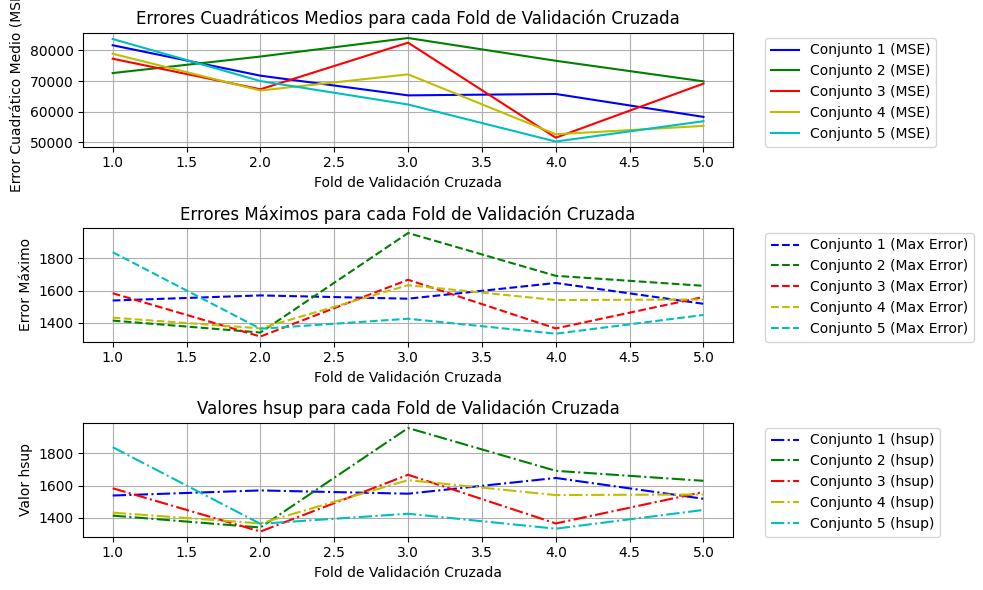

In [ ]:
plt.figure(figsize=(10, 6))

# Inicializar colores para los gráficos
colors = ['b', 'g', 'r','y','c']

# Graficar MSE
plt.subplot(3, 1, 1)
for i, mse in enumerate(mse_errors, start=1):
    plt.plot(range(1, len(mse) + 1), mse, color=colors[i - 1], label=f"Conjunto {i} (MSE)")
plt.xlabel('Fold de Validación Cruzada')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('Errores Cuadráticos Medios para cada Fold de Validación Cruzada')
plt.legend()
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

# Graficar Max Error
plt.subplot(3, 1, 2)
for i, max_error in enumerate(max_error_values, start=1):
    plt.plot(range(1, len(max_error) + 1), max_error, linestyle='--', color=colors[i - 1], label=f"Conjunto {i} (Max Error)")
plt.xlabel('Fold de Validación Cruzada')
plt.ylabel('Error Máximo')
plt.title('Errores Máximos para cada Fold de Validación Cruzada')
plt.legend()
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)

# Graficar hsup
plt.subplot(3, 1, 3)
for i, hsup in enumerate(hsup_values, start=1):
    plt.plot(range(1, len(hsup) + 1), hsup, linestyle='-.', color=colors[i - 1], label=f"Conjunto {i} (hsup)")
plt.xlabel('Fold de Validación Cruzada')
plt.ylabel('Valor hsup')
plt.title('Valores hsup para cada Fold de Validación Cruzada')
plt.legend()
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
plt.tight_layout()
plt.show()